In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import os
import pickle

In [2]:
os.getcwd()

'C:\\work\\oxford_diss'

## Exponential Contact Rate Model

Comparing simulation results of CTMC SIR model with contact rate
$$
B(t) = A + Be^{-\alpha t}.
$$
We compare the simulations to our novel ODE approximation model given by the solution to 
$$
\frac{dq}{dt} = -q^2 + (B(t) + \mu)q - \mu.
$$
In this application, we consider the contact rate function $B(t)$ with parameter values $A = 1.4, B = 1, \alpha = 0.5$ and removal parameter $\mu = 1$.

In [3]:
# parameters of the model

A = 1.4
B = 1
alpha = 1
mu = 1

def rate(t, A, B, alpha):
    # contact rate for the model
    return A + B*np.exp(-alpha*t)

def exponential_decay_rate(t, A, a):
    return A*np.exp(-a*t)

### Simulating the CTMC Exponential Model

We note that for a model with an exponential propensity function, instead of solving the integral for the next reaction time, we can instead solve the Lambert Function. This is described further in the paper [1]. We extend the work of the paper given above by considering a propensity function with both time dependent and time dependent parts. If we let $i$ denote an infection occuring and $r$ a removal with propensities
\begin{align}
    &a_i(t) = A + Be^{-\alpha t} \\
    &a_r = \mu.
\end{align}
The probability that the reaction $i$ occurs at time $t + \tau$ is then given by
\begin{align}
    \mathbb{P}(i, \tau) &= (A + Be^{-\alpha ( t+ \tau)})\exp\left\{ -\int_0^\tau a_i(t + \tau') + a_r d\tau'  \right\} \\
      &= (A + Be^{-\alpha ( t+ \tau)})\exp\left\{ - \tau (A + \mu) - f_{\alpha}(\tau)Be^{-\alpha t}\right\}. 
\end{align}
where $f_{\alpha}(\tau)$ is the function described in by Equation (9) of [1]. That is
\begin{equation}
    f_{\alpha}(\tau) = \frac{1}{\alpha}(1 - e^{-\alpha \tau}).
\end{equation}

From [1], the next reaction time is therefore a solution of the following
\begin{equation}
u_1 = \exp\left\{  -f_{\alpha}(\tau)Be^{-\alpha t} - \tau(A + \mu) \right\}
\end{equation}
where $u_1$ is a randomly generated uniform number. The time to the next reaction $\tau$ is therefore given by a solution to the Lambert function

\begin{equation}
    \tau = \frac{1}{\alpha} W\left(  D\exp[ D + \beta]   \right) - D - \beta
\end{equation}
where $D = \frac{Be^{-\alpha t}}{A + \mu}$ and $\beta = \alpha \log(u_1) / (A + \mu)$. In this part, we have omitted the population weights of the propensities which must be taken into account when implementing (i.e $\mu$ is actually $\mu I(t)$ and $A + Be^{-\alpha t}$ represents $(A + Be^{-\alpha t})S(t)I(t)$ ).


[1] - https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1334982

In [4]:
import math

def time_dependent_gillespie_algo(t0, t_final, X_0, parameters):
    from scipy.special import lambertw
    
    """
    
    Temporal Gillespie Algorithm for a typical SIR CTMC model:
    S + I -> I + I (with rate B(t) = A + B*e^{-a*t})
    I -> R (with constant rate gamma)
    
    Parameters: 
    - t0: initial infective time
    - t_final: final simulation time
    - X_0: initial breakdown of population: (S, I, R)(0)
    - parameters: [A, B, alpha, mu]
    
    Returns:
    - t_hist: history of when reactions occur
    - state_hist: the evolution of the epidemic.
    
    """
    
    def calc_a_i(X, t, parameters, N): 
        A = parameters[0]*X[0]*X[1] # A
        B = parameters[1]*X[0]*X[1]*np.exp(-parameters[2]*t) # Be^{-\alpha t}
        return A/N, B/N
        
    def calc_a_r(X, t, parameters):
        return parameters[3]*X[1] # \mu
    
    def f(tau, parameters):
        return (1 / parameters[3])*(1 - np.exp(-parameters[3] * tau))
    
    def calc_a0(X, t, parameters, N):
        A, B = calc_a_i(X, t, parameters, N)
        A = A*X[0]*X[1]
        B = B*X[0]*X[1]
        mu = calc_a_r(X, t, parameters)
        mu = mu*X[1]
        a_list = [(A + B)/N, mu]
        a0 = np.sum(a_list)
        return a0, a_list

    def v1():
        # transmition, S + I -> I + I
        return np.array((-1, +1, 0))
    
    def v2():
        # recovery, I -> R
        return np.array((0, -1, +1))

    
    S = X_0[0]
    I = X_0[1]
    R = X_0[2]
    N = np.sum(X_0) # population size
    
    t = t0
    state_hist = []
    t_hist = []
    
    stch_vecs = {0:v1, 1:v2}
    
    X = np.asarray(X_0)
    
    while t <= t_final:
        # calculate a_0
        
        A, B = calc_a_i(X, t, parameters, N)
        mu = calc_a_r(X, t, parameters)
        
        # generate a reaction time
        r1 = np.random.rand()
        

        # generate time using Lambert function (see: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1334982)
        alpha = B / (A + mu)
        beta = parameters[3]*np.log(r1) / (A + mu)
        tau = (1 / parameters[3])*(np.real(lambertw(alpha*math.exp(alpha+ beta))) -alpha - beta)
        t += tau
        r2 = np.random.rand()

        # choose which reaction occurs
        
        a0, a_list = calc_a0(X, t, parameters, N)
        for idx in range(len(a_list)):
            if r2*a0 < np.sum(a_list[:idx +1]):
                reaction_idx = idx
                break
            elif idx == (len(a_list) - 1):
                reaction_idx = idx

        # update state vector
        X = X + stch_vecs[reaction_idx]()
        state_hist.append(X)
        t_hist.append(t)
            
    return t_hist, state_hist

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars


0.8576152324676514


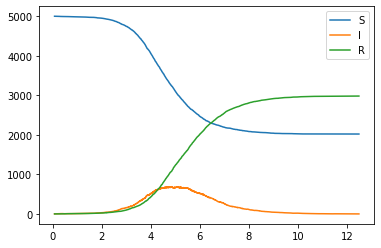

In [253]:
import time

start = time.time()
t_hist, state_hist = time_dependent_gillespie_algo(0, 50, [4999, 1, 0], [0.7, 2, 0.02, 1])
end = time.time()
print(end - start)
plt.plot(t_hist, state_hist)
plt.legend(["S", "I", "R"])
plt.show()

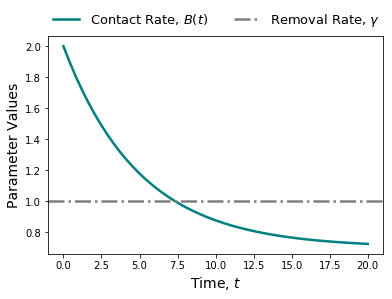

In [25]:
# How the contact rate and removal rate changes in time.

A = 0.7
B = 1.3
alpha = 0.2
mu = 1

t_range = np.linspace(0, 20)
contact_rate = rate(t_range, A, B, alpha)

fig, ax = plt.subplots()

ax.plot(t_range, contact_rate, color = "teal", linewidth = 2.5, label = "Contact Rate, $B(t)$")
ax.axhline(mu, linestyle = "-.", color = "gray", linewidth = 2.5, label = "Removal Rate, $\gamma$")
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, 
            borderaxespad=0, frameon=False, fontsize = 13)
ax.set_xlabel("Time, $t$", fontsize = 14)
ax.set_ylabel("Parameter Values", fontsize = 14)
#plt.savefig("imgs/exp_contact_rate.pdf", bbox_inches = "tight")

In [12]:
# performing many simulations to obtain empirical probability of an epidemic.
import time
start = time.time()

major_thresh = 30
t_range = np.linspace(0, 20, 16)
final_size = {}
for t in t_range:
    sims = []
    for sim in range(5000):
        t_hist, state_hist = time_dependent_gillespie_algo(0 + t, 50 + t, [4999, 1, 0], [A, B, alpha, mu])
        if state_hist[-1][2] > major_thresh:
            sims.append(1)
        else:
            sims.append(0)
    final_size[t] = np.sum(sims) / len(sims)
    print("Completed: " + str(t))
    
end = time.time()
print(end - start)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars


Completed: 0.0
Completed: 1.3333333333333333
Completed: 2.6666666666666665
Completed: 4.0
Completed: 5.333333333333333
Completed: 6.666666666666666
Completed: 8.0
Completed: 9.333333333333332
Completed: 10.666666666666666
Completed: 12.0
Completed: 13.333333333333332
Completed: 14.666666666666666
Completed: 16.0
Completed: 17.333333333333332
Completed: 18.666666666666664
Completed: 20.0
130.63867902755737


In [13]:
# instantenous rate

t_range = np.linspace(0, 20)
instant_rate = 1 - np.minimum(1, 1 / rate(t_range, A, B, alpha))

In [14]:
# ODE approximation from MATLAB ode45

ode_sol = pd.read_csv("data/exp_model_soln.csv", header = None) # see MATLAB file labelled 
ode_time = pd.read_csv("data/time_exp_model_soln.csv", header = None)

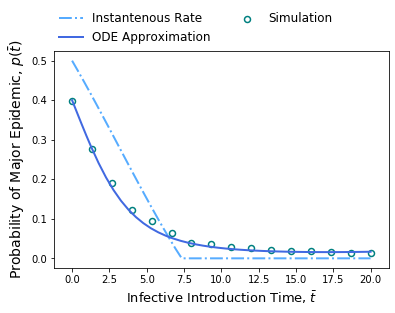

In [24]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots()

ax.plot(t_range, instant_rate, label = "Instantenous Rate", color = "dodgerblue", alpha = 0.75, linewidth = 2, linestyle = "-.")
ax.plot(ode_time, 1 - ode_sol, label = "ODE Approximation", color = "royalblue", linewidth = 2)
ax.scatter(list(final_size.keys()), list(final_size.values()), facecolor = "white", color = "teal", label = "Simulation", linewidth = 1.5)
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, 
            borderaxespad=0, frameon=False, fontsize = 12)
ax.set_ylabel("Probability of Major Epidemic, $p(\\bar{t})$", fontsize = 14)
ax.set_xlabel("Infective Introduction Time, $\\bar{t}$", fontsize = 13)


#plt.savefig("imgs/exp_prob_epidemic_final.pdf", bbox_inches = "tight")
